In [51]:
import pandas as pd
import numpy as np
import copy
import json

gradcpt_data

In [53]:
print(final.shape)
final['Subject'].unique()

(22500, 8)


array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [54]:
final.to_csv(f'all_subjects_gradcpt.csv')

In [44]:
from scipy.ndimage import gaussian_filter1d

TRIAL_N = 75 * 10 # 75 trials = 1 minute
FWHM = 9
SIGMA = FWHM / (2 * np.sqrt(2 * np.log(2)))

def process_responses(trials):
    """Calculate response times (RTs) from the trial data."""
    trials = copy.deepcopy(trials)  # Deep copy to avoid modifying original data
    response_times = [float('inf')] * TRIAL_N

    # Edge case: first trial
    if trials[0]['responses']:
        response_times[0] = trials[0]['responses'][0]

    # Loop 0: unamibiguous correct responses
    for i, trial in enumerate(trials[1:], start=1):
        remaining_responses = []
        for rt in trial['responses']:
            if rt < 320 and not trials[i-1]['is_mountain']:
                response_times[i-1] = min(800 + rt, response_times[i-1])
            elif rt > 560 and not trial['is_mountain']:
                response_times[i] = min(rt, response_times[i])
            else:
                remaining_responses.append(rt)
        trial['responses'] = remaining_responses


    # Loop 1: ambigous presses
    for i, trial in enumerate(trials[1:], start=1):
        for rt in trial['responses']:
            if response_times[i-1] == float('inf') and response_times[i] != float('inf'):
                response_times[i-1] = 800 + rt
            elif response_times[i-1] != float('inf') and response_times[i] == float('inf'):
                response_times[i] = rt
            elif response_times[i-1] == float('inf') and response_times[i] == float('inf'):
                if trials[i-1]['is_mountain']:
                    response_times[i] = rt
                elif trial['is_mountain']:
                    response_times[i-1] = 800 + rt
                else:
                    if rt < 400:
                        response_times[i-1] = 800 + rt
                    else:
                        response_times[i] = rt

    # Replace inf with None
    processed = [None if x == float('inf') else x for x in response_times]
    start_timestamps = [trial['start_timestamp'] for trial in trials]
    is_mountains = [trial['is_mountain'] for trial in trials]
    return processed, start_timestamps, is_mountains

def label(response_times, start_timestamps, is_mountains):
    """Label responses w.r.t RTV aka the trial to trial variation in response time"""
    response_times = np.array(response_times, dtype=float)

    # Z-tranform the sequence
    z_normalized_rt = (response_times - np.nanmean(response_times)) / np.nanstd(response_times)

    # Calculate variance time course
    vtc = np.abs(z_normalized_rt - np.nanmean(z_normalized_rt))

    # Linearly interpolate missing values in the vtc
    nans, x = np.isnan(vtc), lambda z: z.nonzero()[0]
    vtc[nans] = np.interp(x(nans), x(~nans), vtc[~nans])

    # Smooth the VTC
    vtc_smoothed = gaussian_filter1d(vtc, sigma=SIGMA)  # sigma derived from FWHM

    # Determine if there was a response
    responses_bool = [False if not resp else True for resp in responses]

    # Determine "in the zone" (1) and "out of the zone" (0) labels
    median_vtc = np.median(vtc_smoothed)
    zone_labels = [(start_timestamps[i], 1, value, is_mountains[i], responses_bool[i]) if value <= median_vtc else (start_timestamps[i], 0, value, is_mountains[i], responses_bool[i]) for i, value in enumerate(vtc_smoothed)]

    return zone_labels, vtc_smoothed, responses_bool

In [45]:
labels = []
vtcs = []
responses_bools = []
count = 0
total = 0
for i in range(3):
    responses, start_timestamps, is_mountains = process_responses(raw[i])
    labels_i, vtc_i, rsp_i = label(responses, start_timestamps, is_mountains)
    n = len(labels_i)

    count_i = 0
    for j in range(n):
        if processed[i]['in_the_zone'][j] == labels_i[j][1]:
            count_i += 1
    if count_i != n:
        print(f'{i} is not matching')
    count += count_i
    total += n
    labels.append(labels_i)
    vtcs.append(vtc_i)
    responses_bools.append(rsp_i)

print(f'{count}/{total} matches')

2250/2250 matches


In [46]:
dfs = []
for idx, sublist in enumerate(labels):
    df = pd.DataFrame(sublist, columns=['Timestamp', 'Zone', 'Smoothed VTC', 'Mountain', 'Button pressed'])
    df['Trial'] = idx + 1  # Add the index of the sublist as a new column
    df['Subject'] = subject_id
    dfs.append(df)

# Concatenate all DataFrames into one
data = pd.concat(dfs, ignore_index=True)
data.head()

,Timestamp,Zone,Smoothed VTC,Mountain,Button pressed,Trial,Subject
0,1.712909e+09,0,0.856767,False,True,1,10
1,1.712909e+09,0,0.846050,False,True,1,10
2,1.712909e+09,0,0.827186,False,True,1,10
3,1.712909e+09,0,0.804132,False,True,1,10
4,1.712909e+09,0,0.780752,False,True,1,10


In [47]:

data.to_csv(f'subject_{subject_id}_gradcpt.csv')

### plot VTC

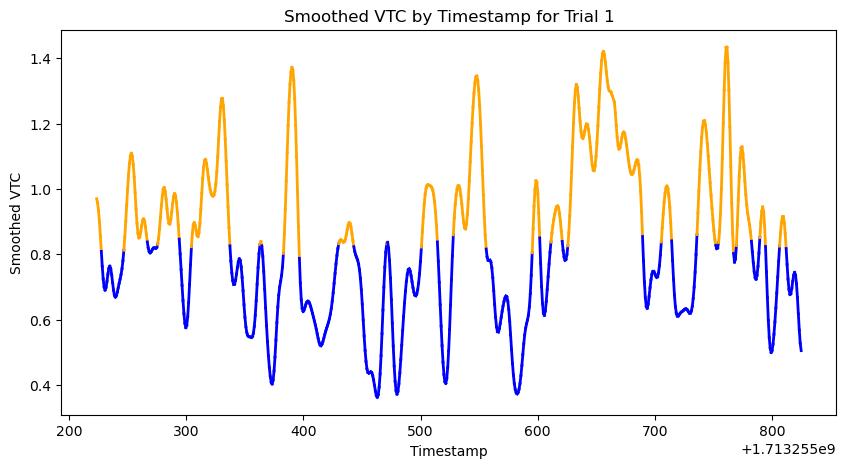

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Filter data for Trial 1
trial_data = data[data['Trial'] == 1]

# Calculate the mean of Smoothed VTC
mean_vtc = trial_data['Smoothed VTC'].mean()

# Plotting
plt.figure(figsize=(10, 5))
for i in range(len(trial_data) - 1):
    x_values = trial_data['Timestamp'][i:i+2]
    y_values = trial_data['Smoothed VTC'][i:i+2]
    color = 'orange' if y_values.mean() > mean_vtc else 'blue'
    plt.plot(x_values, y_values, color=color, linewidth=2)

# Add labels and title
plt.title('Smoothed VTC by Timestamp for Trial 1')
plt.xlabel('Timestamp')
plt.ylabel('Smoothed VTC')
plt.show()


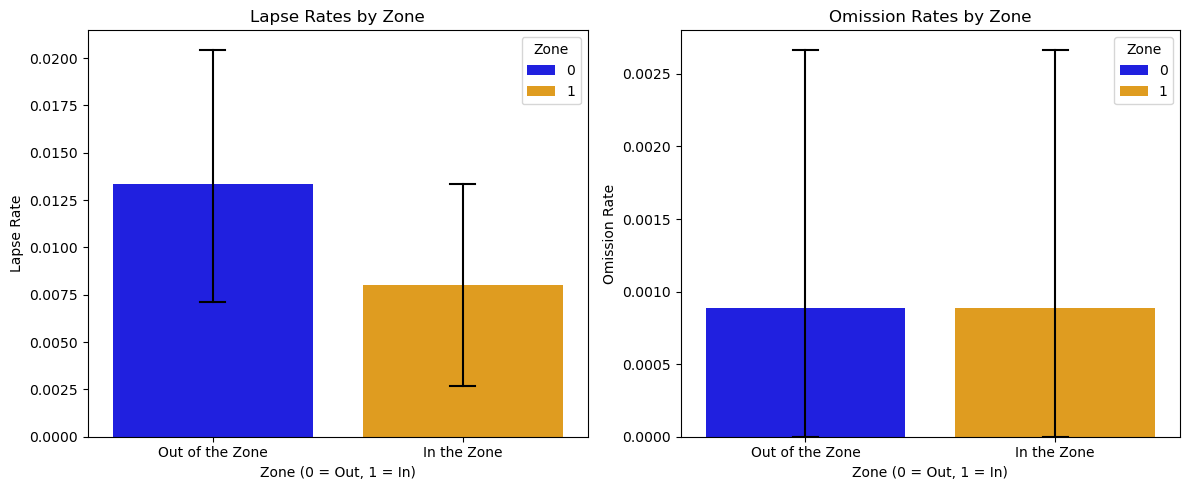

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import numpy as np


# Define lapses and omissions
data['Lapse'] = (data['Mountain'] & data['Button pressed'])
data['Omission'] = (~data['Mountain'] & ~data['Button pressed'])

# Calculate the standard error for Lapse and Omission rates
lapse_se = data.groupby('Zone')['Lapse'].sem()
omission_se = data.groupby('Zone')['Omission'].sem()

# Prepare subplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Colors for the zones
colors = ["blue", "orange"]

# Lapse Rates Plot
sns.barplot(x='Zone', y='Lapse', data=data, ax=axs[0], hue='Zone', palette=colors, capsize=0.1, err_kws={'color': 'black', 'linewidth': 1.5})
axs[0].set_title('Lapse Rates by Zone')
axs[0].set_xlabel('Zone (0 = Out, 1 = In)')
axs[0].set_ylabel('Lapse Rate')
axs[0].xaxis.set_major_locator(FixedLocator([0, 1]))
axs[0].set_xticklabels(['Out of the Zone', 'In the Zone'])

# Omission Rates Plot
sns.barplot(x='Zone', y='Omission', data=data, ax=axs[1], hue='Zone', palette=colors, capsize=0.1, err_kws={'color': 'black', 'linewidth': 1.5})
axs[1].set_title('Omission Rates by Zone')
axs[1].set_xlabel('Zone (0 = Out, 1 = In)')
axs[1].set_ylabel('Omission Rate')
axs[1].xaxis.set_major_locator(FixedLocator([0, 1]))
axs[1].set_xticklabels(['Out of the Zone', 'In the Zone'])

# Show plot
plt.tight_layout()
plt.show()
